In [10]:
import numpy as np 
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web 
import pandas_ta as ta
import matplotlib.pyplot as plt
from datetime import date

plt.style.use('fivethirtyeight')
# yf.pdr_override()

In [11]:
stocksymbols = ['TATAMOTORS.NS']
startdate = date(2017, 8, 4)
end_date = date.today()

print(end_date)


def getMyPortfolio(stocks=stocksymbols, start=startdate, end=end_date):
 
    data = yf.download(stocks, start=start, end=end)
    return data




2024-12-13


In [12]:
data = getMyPortfolio()
print(data)

[*********************100%***********************]  1 of 1 completed

Price                         Adj Close         Close          High  \
Ticker                    TATAMOTORS.NS TATAMOTORS.NS TATAMOTORS.NS   
Date                                                                  
2017-08-04 00:00:00+00:00    432.910645    435.600006    438.750000   
2017-08-07 00:00:00+00:00    427.345215    430.000000    439.799988   
2017-08-08 00:00:00+00:00    427.345215    430.000000    435.500000   
2017-08-09 00:00:00+00:00    413.481354    416.049988    429.899994   
2017-08-10 00:00:00+00:00    377.852722    380.200012    403.600006   
...                                 ...           ...           ...   
2024-12-06 00:00:00+00:00    816.799988    816.799988    818.849976   
2024-12-09 00:00:00+00:00    798.750000    798.750000    820.349976   
2024-12-10 00:00:00+00:00    799.900024    799.900024    810.450012   
2024-12-11 00:00:00+00:00    799.099976    799.099976    806.950012   
2024-12-12 00:00:00+00:00    786.349976    786.349976    802.000000   

Price

In [13]:
data['SMA 30'] = data['Close'].rolling(window=30).mean()
data['SMA 100'] = data['Close'].rolling(window=100).mean()

def buy_sell(data):
    signalBuy = []
    signalSell = []
    position = False

    for i in range(len(data)):
        if data['SMA 30'].iloc[i] > data['SMA 100'].iloc[i]:  # Use iloc for positional indexing
            if not position:
                signalBuy.append(data['Adj Close'].iloc[i])
                signalSell.append(np.nan)
                position = True
            else:
                signalBuy.append(np.nan)
                signalSell.append(np.nan)
        elif data['SMA 30'].iloc[i] < data['SMA 100'].iloc[i]:  # Use iloc here as well
            if position:
                signalBuy.append(np.nan)
                signalSell.append(data['Adj Close'].iloc[i])
                position = False
            else:
                signalBuy.append(np.nan)
                signalSell.append(np.nan)
        else:
            signalBuy.append(np.nan)
            signalSell.append(np.nan)
            
    data['Buy_Signal_price'] = signalBuy
    data['Sell_Signal_price'] = signalSell

    return pd.Series([signalBuy, signalSell], index=["Buy Signal", "Sell Signal"])


# Apply the function to get signals
signals = buy_sell(data)
data["Buy Signal"] = signals["Buy Signal"]
data["Sell Signal"] = signals["Sell Signal"]

print(data[['Close', 'SMA 30', 'SMA 100', 'Buy Signal', 'Sell Signal']].tail())

Price                             Close      SMA 30     SMA 100 Buy Signal  \
Ticker                    TATAMOTORS.NS                                      
Date                                                                         
2024-12-06 00:00:00+00:00    816.799988  809.869999  954.532999        NaN   
2024-12-09 00:00:00+00:00    798.750000  807.161666  952.276000        NaN   
2024-12-10 00:00:00+00:00    799.900024  805.015000  950.063500        NaN   
2024-12-11 00:00:00+00:00    799.099976  802.369999  947.808999        NaN   
2024-12-12 00:00:00+00:00    786.349976  800.489998  945.772499        NaN   

Price                     Sell Signal  
Ticker                                 
Date                                   
2024-12-06 00:00:00+00:00         NaN  
2024-12-09 00:00:00+00:00         NaN  
2024-12-10 00:00:00+00:00         NaN  
2024-12-11 00:00:00+00:00         NaN  
2024-12-12 00:00:00+00:00         NaN  


C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\matplotlib\cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\matplotlib\collections.py:197: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  offsets = np.asanyarray(offsets, float)


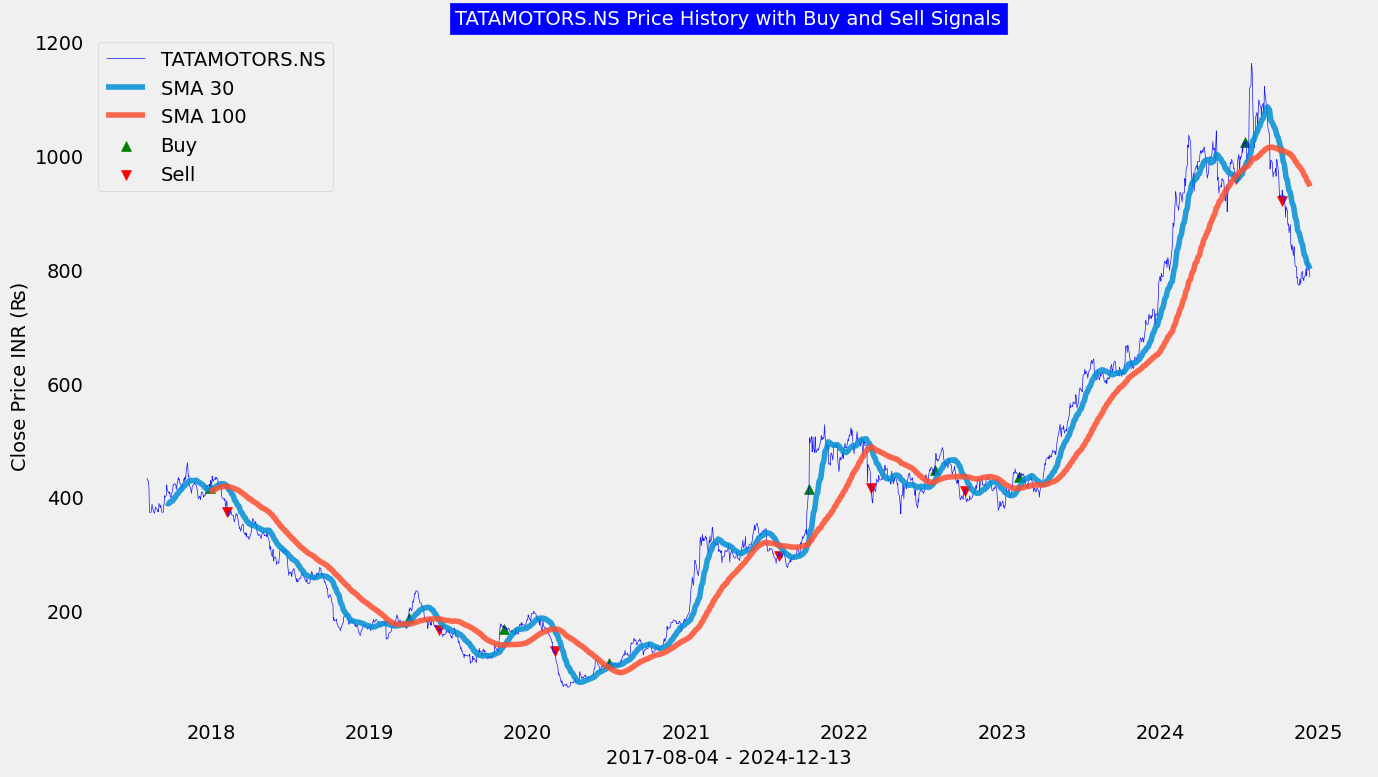

In [14]:

fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(data['Adj Close'], label=stocksymbols[0], linewidth=0.5, color='blue', alpha=0.9)
ax.plot(data['SMA 30'], label='SMA 30', alpha=0.85)
ax.plot(data['SMA 100'], label='SMA 100', alpha=0.85)
buy_signals = data['Buy_Signal_price'].dropna()
ax.scatter(buy_signals.index, buy_signals, label='Buy', marker='^', color='green', alpha=1, s=50)
sell_signals = data['Sell_Signal_price'].dropna()
ax.scatter(sell_signals.index, sell_signals, label='Sell', marker='v', color='red', alpha=1, s=50)
ax.set_title(f"{stocksymbols[0]} Price History with Buy and Sell Signals", fontsize=14, backgroundcolor='blue', color='white')
ax.set_xlabel(f'{startdate} - {end_date}', fontsize=14)
ax.set_ylabel('Close Price INR (₨)', fontsize=14)
ax.legend()

ax.grid()
plt.tight_layout()  
plt.show()


In [15]:
def calculate_macd(df, short_window=12, long_window=26, signal_window=9):
    
    df['MACD_12_26_9'] = df['Adj Close'].ewm(span=short_window, adjust=False).mean() - df['Adj Close'].ewm(span=long_window, adjust=False).mean()
    df['MACDs_12_26_9'] = df['MACD_12_26_9'].ewm(span=signal_window, adjust=False).mean()
    df['MACDh_12_26_9'] = df['MACD_12_26_9'] - df['MACDs_12_26_9']

    # Print the results
    print(df[['MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9']])

    return df
    
data = calculate_macd(data)
print(data)

Price                     MACD_12_26_9 MACDh_12_26_9 MACDs_12_26_9
Ticker                                                            
Date                                                              
2017-08-04 00:00:00+00:00     0.000000      0.000000      0.000000
2017-08-07 00:00:00+00:00    -0.443966     -0.355173     -0.088793
2017-08-08 00:00:00+00:00    -0.786743     -0.558360     -0.228383
2017-08-09 00:00:00+00:00    -2.152284     -1.539121     -0.613163
2017-08-10 00:00:00+00:00    -6.039795     -4.341305     -1.698490
...                                ...           ...           ...
2024-12-06 00:00:00+00:00   -16.580865      7.829842    -24.410707
2024-12-09 00:00:00+00:00   -15.109272      7.441148    -22.550420
2024-12-10 00:00:00+00:00   -13.692390      7.086424    -20.778814
2024-12-11 00:00:00+00:00   -12.490080      6.630987    -19.121067
2024-12-12 00:00:00+00:00   -12.422856      5.358569    -17.781425

[1816 rows x 3 columns]
Price                         Adj Clo

In [16]:
import numpy as np

def MACD_Strategy(df, risk):
    MACD_Buy = []
    MACD_Sell = []
    position = False

    for i in range(0, len(df)):
        # Use .iloc for positional access
        macd_value = df['MACD_12_26_9'].iloc[i]
        macd_signal = df['MACDs_12_26_9'].iloc[i]
        adj_close = df['Adj Close'].iloc[i]
        
        if macd_value > macd_signal:
            MACD_Sell.append(np.nan)
            if not position:
                MACD_Buy.append(adj_close)
                position = True
            else:
                MACD_Buy.append(np.nan)
        elif macd_value < macd_signal:
            MACD_Buy.append(np.nan)
            if position:
                MACD_Sell.append(adj_close)
                position = False
            else:
                MACD_Sell.append(np.nan)
        elif position and adj_close < MACD_Buy[-1] * (1 - risk):
            MACD_Sell.append(adj_close)
            MACD_Buy.append(np.nan)
            position = False
        elif position and adj_close < df['Adj Close'].iloc[i - 1] * (1 - risk):
            MACD_Sell.append(adj_close)
            MACD_Buy.append(np.nan)
            position = False
        else:
            MACD_Buy.append(np.nan)
            MACD_Sell.append(np.nan)

    # Add columns to DataFrame
    df['MACD_Buy_Signal_price'] = MACD_Buy
    df['MACD_Sell_Signal_price'] = MACD_Sell
    
    
    return df

# Run the strategy
data_with_signals = MACD_Strategy(data, 0.025)
data_with_signals


Price,Adj Close,Close,High,Low,Open,Volume,SMA 30,SMA 100,Buy_Signal_price,Sell_Signal_price,Buy Signal,Sell Signal,MACD_12_26_9,MACDs_12_26_9,MACDh_12_26_9,MACD_Buy_Signal_price,MACD_Sell_Signal_price
Ticker,TATAMOTORS.NS,TATAMOTORS.NS,TATAMOTORS.NS,TATAMOTORS.NS,TATAMOTORS.NS,TATAMOTORS.NS,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,
2017-08-04 00:00:00+00:00,432.910645,435.600006,438.750000,433.450012,435.100006,4166729,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN
2017-08-07 00:00:00+00:00,427.345215,430.000000,439.799988,425.299988,438.600006,6461815,NaN,NaN,NaN,NaN,NaN,NaN,-0.443966,-0.088793,-0.355173,NaN,NaN
2017-08-08 00:00:00+00:00,427.345215,430.000000,435.500000,426.000000,432.000000,7134979,NaN,NaN,NaN,NaN,NaN,NaN,-0.786743,-0.228383,-0.558360,NaN,NaN
2017-08-09 00:00:00+00:00,413.481354,416.049988,429.899994,415.000000,428.799988,10849567,NaN,NaN,NaN,NaN,NaN,NaN,-2.152284,-0.613163,-1.539121,NaN,NaN
2017-08-10 00:00:00+00:00,377.852722,380.200012,403.600006,375.250000,401.000000,28114017,NaN,NaN,NaN,NaN,NaN,NaN,-6.039795,-1.698490,-4.341305,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-06 00:00:00+00:00,816.799988,816.799988,818.849976,785.299988,793.000000,19716910,809.869999,954.532999,NaN,NaN,NaN,NaN,-16.580865,-24.410707,7.829842,NaN,NaN
2024-12-09 00:00:00+00:00,798.750000,798.750000,820.349976,797.000000,816.799988,15573233,807.161666,952.276000,NaN,NaN,NaN,NaN,-15.109272,-22.550420,7.441148,NaN,NaN


In [17]:
def MACD_color(data):
    MACD_color = []
    
    
    MACD_color.append(False)
    
    for i in range(1, len(data)):  # Start from index 1
        if data['MACDh_12_26_9'].iloc[i] > data['MACDh_12_26_9'].iloc[i - 1]:
            MACD_color.append(True)
        else:
            MACD_color.append(False)
    
    return MACD_color

# Call the function and assign the result to a new column in your DataFrame
data['positive'] = MACD_color(data)


C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\matplotlib\cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\matplotlib\collections.py:197: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  offsets = np.asanyarray(offsets, float)


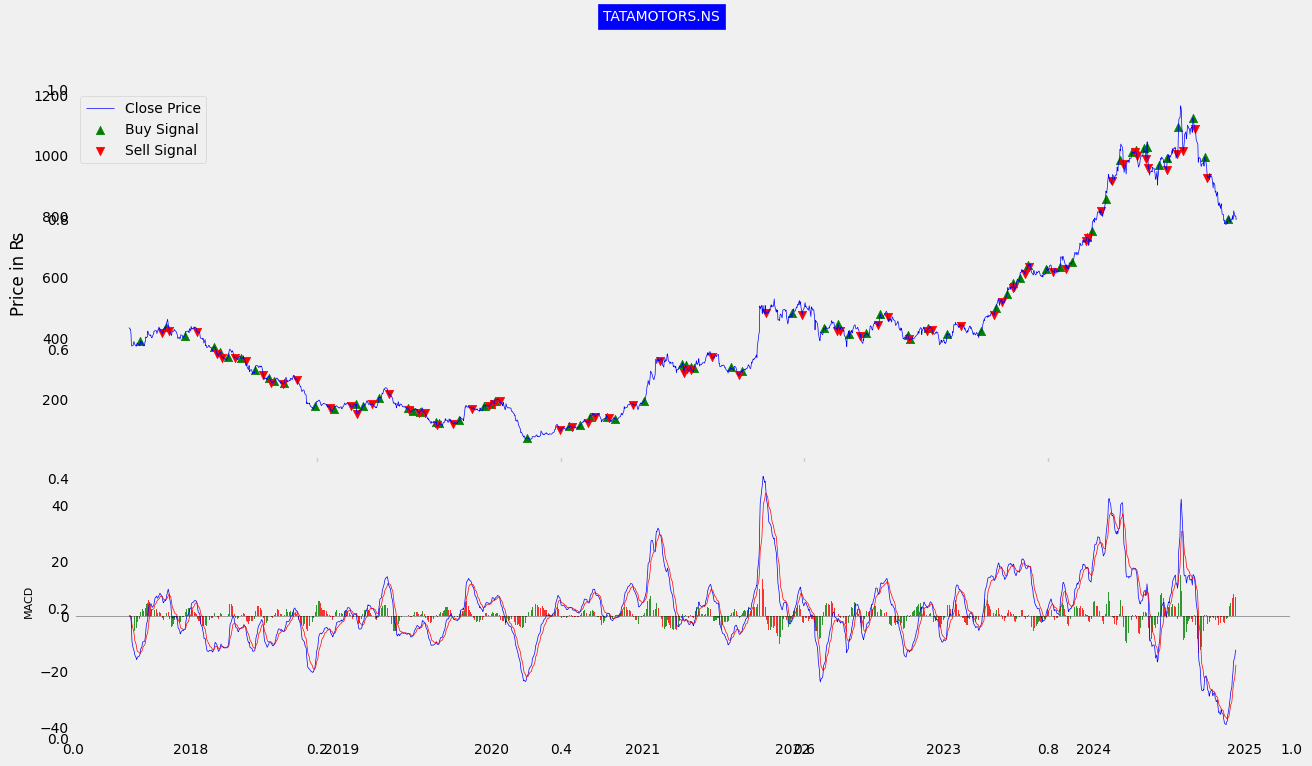

In [18]:
import matplotlib.pyplot as plt


plt.rcParams.update({'font.size': 10})


fig, ax1 = plt.subplots(figsize=(14, 8))


fig.suptitle(stocksymbols[0], fontsize=10, backgroundcolor='blue', color='white')


ax1 = plt.subplot2grid((14, 14), (0, 0), rowspan=8, colspan=14)
ax1.set_ylabel('Price in ₨')


ax1.plot(data.index, data['Adj Close'], label='Close Price', linewidth=0.5, color='blue')


ax1.scatter(data.index, data['MACD_Buy_Signal_price'], color='green', marker='^', alpha=1, label='Buy Signal')
ax1.scatter(data.index, data['MACD_Sell_Signal_price'], color='red', marker='v', alpha=1, label='Sell Signal')


ax1.legend()
ax1.grid()
ax1.set_xlabel('Date', fontsize=8)


ax2 = plt.subplot2grid((14, 14), (8, 0), rowspan=6, colspan=14)
ax2.set_ylabel('MACD', fontsize=8)


ax2.plot(data.index, data['MACD_12_26_9'], label='MACD', linewidth=0.5, color='blue')
ax2.plot(data.index, data['MACDs_12_26_9'], label='Signal', linewidth=0.5, color='red')


ax2.bar(data.index, data['MACDh_12_26_9'], label='MACD Histogram', 
        color=data['positive'].map({True: 'g', False: 'r'}), width=1, alpha=0.8)
ax2.axhline(0, color='black', linewidth=0.5, alpha=0.5)
ax2.grid()
plt.show()
